In [20]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from collections import Counter
import heapq
import math

In [21]:
# Represents a node in the Huffman tree
class Node:
    def __init__(self, symbol=None, frequency=None):
        self.symbol = symbol
        self.frequency = frequency
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.frequency < other.frequency

# Function to build Huffman tree
def build_huffman_tree(symbol_counts, max_entries=None):
    if max_entries:
        # keep only the most frequent symbols
        symbol_counts = dict(symbol_counts.most_common(max_entries))  

    # create a priority queue for each symbol
    priority_queue = [Node(symbol, freq) for symbol, freq in symbol_counts.items()]
    heapq.heapify(priority_queue)

     # merge the two least frequent nodes iteratively
    while len(priority_queue) > 1:
        left_child = heapq.heappop(priority_queue)
        right_child = heapq.heappop(priority_queue)
        merged_node = Node(frequency=left_child.frequency + right_child.frequency)
        merged_node.left = left_child
        merged_node.right = right_child
        heapq.heappush(priority_queue, merged_node)

    return priority_queue[0], symbol_counts  

# recursively generates Huffman codes for each symbol
def generate_huffman_codes(node, code="", huffman_codes={}):
    if node is not None:
        if node.symbol is not None:
            huffman_codes[node.symbol] = code
        generate_huffman_codes(node.left, code + "0", huffman_codes)
        generate_huffman_codes(node.right, code + "1", huffman_codes)

    return huffman_codes

# Calc the entropy based on symbol probabilities.
def compute_entropy(symbol_counts):
    total_symbols = sum(symbol_counts.values())
    probabilities = [count / total_symbols for count in symbol_counts.values()]
    return -sum(p * math.log2(p) for p in probabilities if p > 0)

# Calc avg Huffman code length
def compute_avg_huffman_length(huffman_codes, symbol_counts):
    total_symbols = sum(symbol_counts.values())
    weighted_lengths = [len(huffman_codes[symbol]) * (count / total_symbols) for symbol, count in symbol_counts.items()]
    return sum(weighted_lengths)

# replace each symbol with its Huffman code
def huffman_encode(data, huffman_codes):
    return "".join(huffman_codes.get(symbol, "") for symbol in data)

# decodes Huffman-encoded binary string
def huffman_decode(encoded_data, huffman_codes):
    reverse_codes = {code: symbol for symbol, code in huffman_codes.items()}
    decoded_data = []
    buffer = ""
    for bit in encoded_data:
        buffer += bit
        if buffer in reverse_codes:
            decoded_data.append(reverse_codes[buffer])
            buffer = ""
    return np.array(decoded_data, dtype=np.int16)

# CalcRMSE between original and decoded data
def compute_rmse(original, decoded):
    original = np.array(original, dtype=np.int16)
    decoded = np.array(decoded, dtype=np.int16)

    # ensures the same length
    min_length = min(len(original), len(decoded))
    original = original[:min_length]
    decoded = decoded[:min_length]

    rmse = np.sqrt(np.mean((original - decoded) ** 2))
    # Normalize RMSE to scale [0;1]
    max_amplitude = np.max(np.abs(original))
    normalized_rmse = rmse / max_amplitude if max_amplitude > 0 else 0  # not to divide by zero

    return rmse, normalized_rmse


compression_ratios = {}
rmse_values = {}
encoding_times = []
decoding_times = []
total_compressed_length = 0

output_folder = os.path.join(base_folder, "decoded_wav")  
os.makedirs(output_folder, exist_ok=True)

for file_name, (sampling_rate, original_data) in speech_files.items():
    
    # Measure encoding
    encode_start = time.time()
    encoded_data = huffman_encode(original_data, huffman_codes)
    encode_end = time.time()
    encoding_time = encode_end - encode_start
    encoding_times.append(encoding_time)

    # Measure decoding 
    decode_start = time.time()
    decoded_data = huffman_decode(encoded_data, huffman_codes)
    decode_end = time.time()
    decoding_time = decode_end - decode_start
    decoding_times.append(decoding_time)
    
    # Compute compression ratio and RMSE
    compression_ratio = (len(original_data) * 16) / len(encoded_data) if len(encoded_data) > 0 else float('inf')
    compression_ratios[file_name] = compression_ratio
    rmse, normalized_rmse = compute_rmse(original_data, decoded_data)
    rmse_values[file_name] = rmse

    total_compressed_length += len(encoded_data)  
    decoded_file_path = os.path.join(output_folder, f"decoded_{file_name}")
    wavfile.write(decoded_file_path, sampling_rate, decoded_data)
    
    print(f"File: {file_name}, Compression Ratio: {compression_ratio:.2f}, RMSE: {rmse:.2f}, Encoding Time: {encoding_time:.4f} s, Decoding Time: {decoding_time:.4f} s")
    print(f" - Decoded audio saved at: {decoded_file_path}")


compression_values = list(compression_ratios.values())
avg_compression_ratio = np.mean(compression_values)
variance_compression_ratio = np.var(compression_values)
avg_rmse = np.mean(list(rmse_values.values()))
avg_encoding_time = np.mean(encoding_times)
avg_decoding_time = np.mean(decoding_times)

print(f"\nMetrics results:")
print(f"Avg Compression Ratio: {avg_compression_ratio:.2f}")
print(f"Compression Ratio Variance: {variance_compression_ratio:.2f}")
print(f"Avg RMSE: {avg_rmse:.2f}")
print(f"Avg Encoding Time: {avg_encoding_time:.4f} s")
print(f"Avg Decoding Time: {avg_decoding_time:.4f} s")
print(f"Total Length of Encoded Data: {total_compressed_length} bits")




File: SA2.wav, Compression Ratio: 1.28, RMSE: 0.00, Encoding Time: 0.0111 s, Decoding Time: 0.0519 s
 - Decoded audio saved at: C:/TUDelft/Q3/data_entropy/project_huffman\decoded_wav\decoded_SA2.wav
File: SI2293.wav, Compression Ratio: 1.25, RMSE: 0.00, Encoding Time: 0.0060 s, Decoding Time: 0.0431 s
 - Decoded audio saved at: C:/TUDelft/Q3/data_entropy/project_huffman\decoded_wav\decoded_SI2293.wav
File: SI602.wav, Compression Ratio: 1.27, RMSE: 0.00, Encoding Time: 0.0060 s, Decoding Time: 0.0520 s
 - Decoded audio saved at: C:/TUDelft/Q3/data_entropy/project_huffman\decoded_wav\decoded_SI602.wav
File: SX374.wav, Compression Ratio: 1.33, RMSE: 0.00, Encoding Time: 0.0047 s, Decoding Time: 0.0279 s
 - Decoded audio saved at: C:/TUDelft/Q3/data_entropy/project_huffman\decoded_wav\decoded_SX374.wav
File: SX199.wav, Compression Ratio: 1.32, RMSE: 0.00, Encoding Time: 0.0062 s, Decoding Time: 0.0527 s
 - Decoded audio saved at: C:/TUDelft/Q3/data_entropy/project_huffman\decoded_wav\decod


Training Data Size: 404282
Entropy of Source: 12.45 bits
Average Huffman Code Length: 12.48 bits
Time to build Huffman Tree: 0.3300 seconds


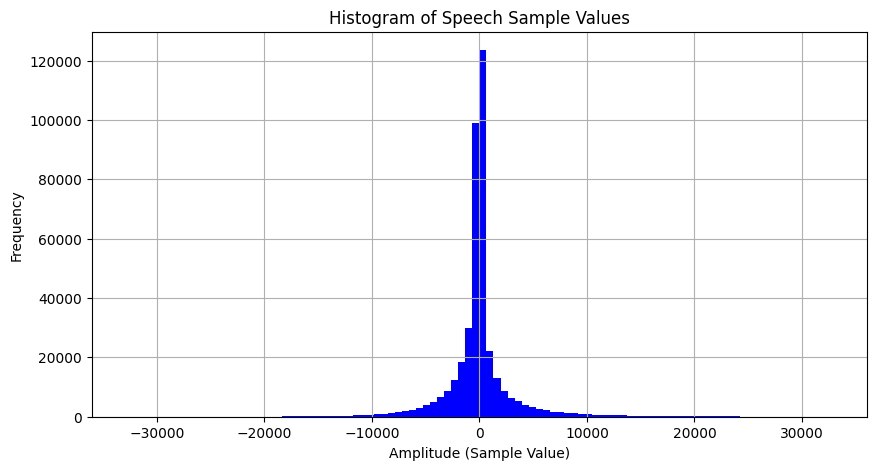

In [22]:
base_folder = r"C:/TUDelft/Q3/data_entropy/project_huffman"
selected_folders = ["M1", "M2", "M3", "M4", "F1", "F2", "F3", "F4"]

# Store data from files
speech_files = {}
training_data_size = 0  
all_samples = []


for folder in selected_folders:
    folder_path = os.path.join(base_folder, folder, "database", folder)

    for file in os.listdir(folder_path):
        if file.endswith(".wav"):
            filepath = os.path.join(folder_path, file)
            sampling_rate, data = wavfile.read(filepath)

            if len(data.shape) > 1:  
                data = np.mean(data, axis=1).astype(np.int16)

            speech_files[file] = (sampling_rate, data)
            training_data_size += len(data)  
            all_samples.extend(data)

combined_counts = Counter()
for _, data in speech_files.values():
    combined_counts.update(data)

# Build Huffman tree
huffman_tree_start = time.time()
huffman_tree_root, filtered_counts = build_huffman_tree(combined_counts, None)
huffman_tree_end = time.time()
huffman_tree_time = huffman_tree_end - huffman_tree_start

huffman_codes = generate_huffman_codes(huffman_tree_root)

# Compute entropy & avg code length
entropy = compute_entropy(filtered_counts)
avg_huffman_length = compute_avg_huffman_length(huffman_codes, filtered_counts)

print(f"\nTraining Data Size: {training_data_size}")
print(f"Entropy of Source: {entropy:.2f} bits")
print(f"Average Huffman Code Length: {avg_huffman_length:.2f} bits")
print(f"Time to build Huffman Tree: {huffman_tree_time:.4f} seconds")

plt.figure(figsize=(10, 5))
plt.hist(all_samples, bins=100, color='blue')
plt.xlabel("Amplitude (Sample Value)")
plt.ylabel("Frequency")
plt.title("Histogram of Speech Sample Values")
plt.grid(True)
plt.show()

Files: 1, Compression Ratio: 1.36, Encoding Time: 0.0034s, Decoding Time: 0.0387s, Normalized RMSE: 0.0008
Files: 2, Compression Ratio: 1.29, Encoding Time: 0.0148s, Decoding Time: 0.0765s, Normalized RMSE: 0.0008
Files: 4, Compression Ratio: 1.29, Encoding Time: 0.0152s, Decoding Time: 0.1481s, Normalized RMSE: 0.0009
Files: 8, Compression Ratio: 1.30, Encoding Time: 0.0329s, Decoding Time: 0.2667s, Normalized RMSE: 0.0009
Files: 16, Compression Ratio: 1.28, Encoding Time: 0.0601s, Decoding Time: 0.7473s, Normalized RMSE: 0.0000


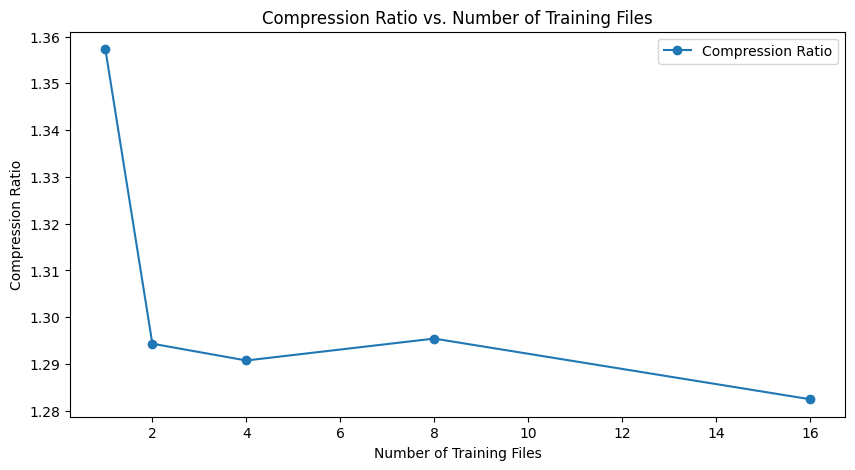

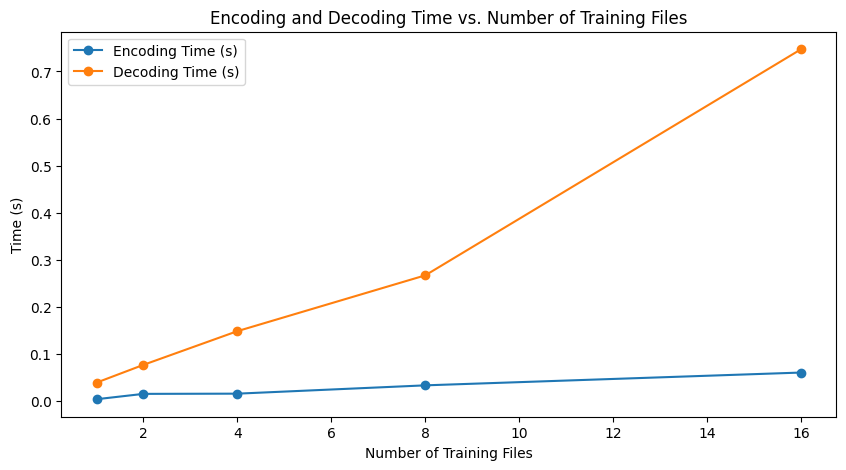

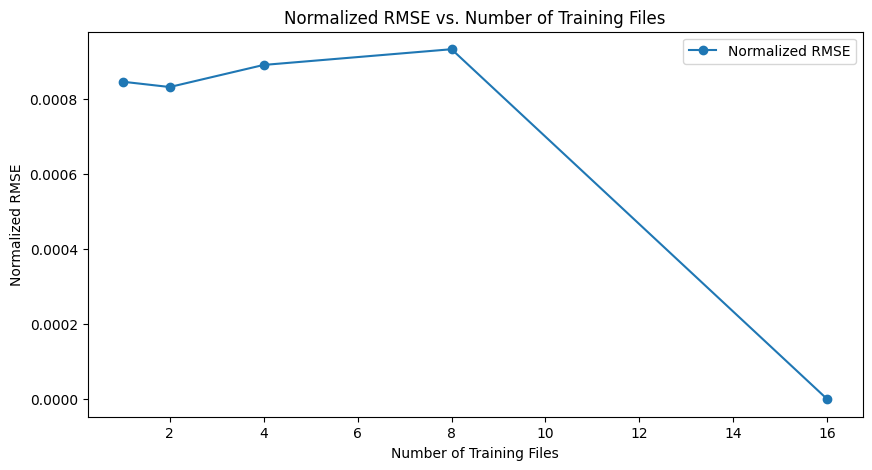

In [23]:


# nr of files to be as training files 
training_file_sizes = [1, 2, 4, 8, 16]

all_files = list(speech_files.keys())
results = {
    "num_files": [],
    "compression_ratios": [],
    "encoding_times": [],
    "decoding_times": [],
    "rmse_values": [],
    "normalized_rmse_values": []
}

# Run compression for different nr of files 
for num_files in training_file_sizes:
    selected_files = all_files[:num_files]

    sample_data = []
    for file in selected_files:
        _, data = speech_files[file]
        sample_data.extend(data)

    # Compute symbol frequencies
    sample_counts = Counter(sample_data)

    # Build Huffman tree
    huffman_tree_root, filtered_counts = build_huffman_tree(sample_counts, None)
    huffman_codes = generate_huffman_codes(huffman_tree_root)

    # Measure encoding 
    encode_start = time.time()
    encoded_data = huffman_encode(sample_data, huffman_codes)
    encode_time = time.time() - encode_start

    # Measure decoding 
    decode_start = time.time()
    decoded_data = huffman_decode(encoded_data, huffman_codes)
    decode_time = time.time() - decode_start

    # Compute compression ratio and RMSE
    compression_ratio = len(sample_data) * 16 / len(encoded_data)
    rmse, normalized_rmse = compute_rmse(sample_data, decoded_data)

    # Store results
    results["num_files"].append(num_files)
    results["compression_ratios"].append(compression_ratio)
    results["encoding_times"].append(encode_time)
    results["decoding_times"].append(decode_time)
    results["rmse_values"].append(rmse)
    results["normalized_rmse_values"].append(normalized_rmse)

    print(f"Files: {num_files}, Compression Ratio: {compression_ratio:.2f}, Encoding Time: {encode_time:.4f}s, Decoding Time: {decode_time:.4f}s, Normalized RMSE: {normalized_rmse:.4f}")


plt.figure(figsize=(10, 5))
plt.plot(results["num_files"], results["compression_ratios"], marker='o', linestyle='-', label="Compression Ratio")
plt.xlabel("Number of Training Files")
plt.ylabel("Compression Ratio")
plt.title("Compression Ratio vs. Number of Training Files")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(results["num_files"], results["encoding_times"], marker='o', linestyle='-', label="Encoding Time (s)")
plt.plot(results["num_files"], results["decoding_times"], marker='o', linestyle='-', label="Decoding Time (s)")
plt.xlabel("Number of Training Files")
plt.ylabel("Time (s)")
plt.title("Encoding and Decoding Time vs. Number of Training Files")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(results["num_files"], results["normalized_rmse_values"], marker='o', linestyle='-', label="Normalized RMSE")
plt.xlabel("Number of Training Files")
plt.ylabel("Normalized RMSE")
plt.title("Normalized RMSE vs. Number of Training Files")
plt.legend()
plt.show()



Huffman Table Size: None

Huffman Table Size: 1024

Huffman Table Size: 512

Huffman Table Size: 256

Huffman Table Size: 128

Huffman Table Size: 64


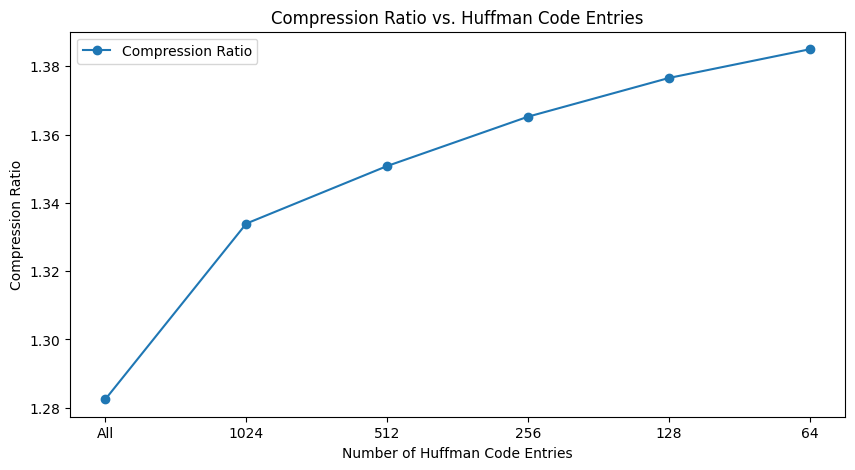

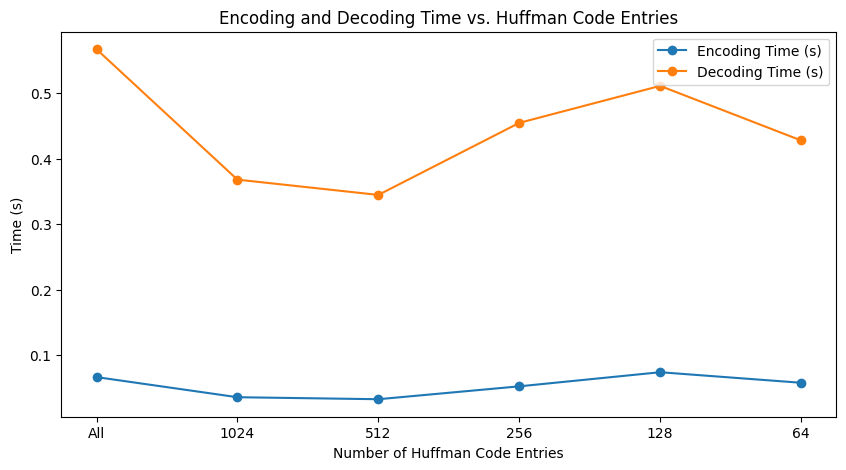

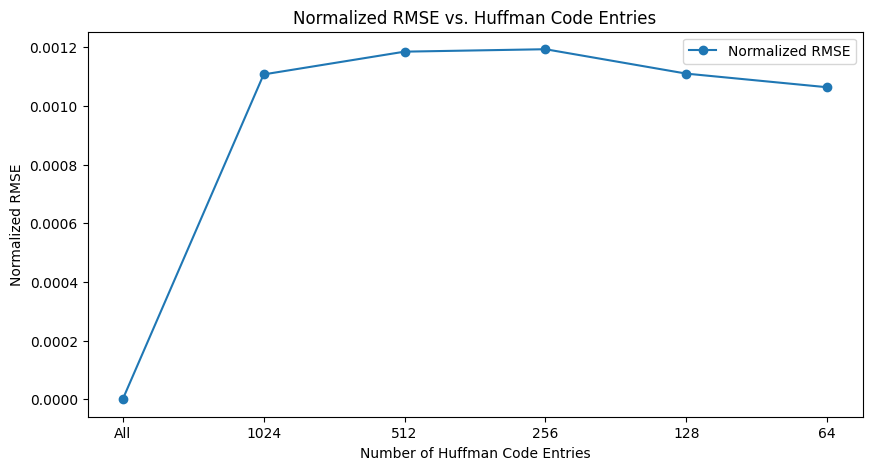

In [ ]:
# Values of max_entries to test
max_entries_list = [None, 1024, 512, 256, 128, 64]

# Store results for plotting
results = {
    "max_entries": [],
    "compression_ratios": [],
    "encoding_times": [],
    "decoding_times": [],
    "rmse_values": [],
    "normalized_rmse_values": []
}

# Combine samples from all 16 files
sample_data = []
for file in list(speech_files.keys())[:16]:
    _, data = speech_files[file]
    sample_data.extend(data)

# running for all max_entries_values
for max_entries in max_entries_list:
    print(f"\nHuffman Table Size: {max_entries}")

    sample_counts = Counter(sample_data)

    # Build Huffman tree
    huffman_tree_root, filtered_counts = build_huffman_tree(sample_counts, max_entries)
    huffman_codes = generate_huffman_codes(huffman_tree_root)

    # Measure encoding
    encode_start = time.time()
    encoded_data = huffman_encode(sample_data, huffman_codes)
    encode_time = time.time() - encode_start

    # Measure decoding
    decode_start = time.time()
    decoded_data = huffman_decode(encoded_data, huffman_codes)
    decode_time = time.time() - decode_start

    # Convert decoded data to int16 and align length
    decoded_data = np.array(decoded_data, dtype=np.int16)
    min_length = min(len(sample_data), len(decoded_data))
    sample_data = sample_data[:min_length]
    decoded_data = decoded_data[:min_length]

    # Compute compression ratio and RMSE
    compression_ratio = len(sample_data) * 16 / len(encoded_data)
    rmse, normalized_rmse = compute_rmse(sample_data, decoded_data)
    
    print(f"Max Entries: {max_entries}, Compression Ratio: {compression_ratio:.2f}, Encoding Time: {encode_time:.4f}s, Decoding Time: {decode_time:.4f}s, RMSE: {rmse:.2f}, Normalized RMSE: {normalized_rmse:.4f}")

    # Store results
    results["max_entries"].append(max_entries if max_entries is not None else "All")
    results["compression_ratios"].append(compression_ratio)
    results["encoding_times"].append(encode_time)
    results["decoding_times"].append(decode_time)
    results["rmse_values"].append(rmse)
    results["normalized_rmse_values"].append(normalized_rmse)



plt.figure(figsize=(10, 5))
plt.plot(results["max_entries"], results["compression_ratios"], marker='o', linestyle='-', label="Compression Ratio")
plt.xlabel("Number of Huffman Code Entries")
plt.ylabel("Compression Ratio")
plt.title("Compression Ratio vs. Huffman Code Entries")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(results["max_entries"], results["encoding_times"], marker='o', linestyle='-', label="Encoding Time (s)")
plt.plot(results["max_entries"], results["decoding_times"], marker='o', linestyle='-', label="Decoding Time (s)")
plt.xlabel("Number of Huffman Code Entries")
plt.ylabel("Time (s)")
plt.title("Encoding and Decoding Time vs. Huffman Code Entries")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(results["max_entries"], results["normalized_rmse_values"], marker='o', linestyle='-', label="Normalized RMSE")
plt.xlabel("Number of Huffman Code Entries")
plt.ylabel("Normalized RMSE")
plt.title("Normalized RMSE vs. Huffman Code Entries")
plt.legend()
plt.show()
